# 🧠 NYC Taxi Trip Duration — Phase 1 (Neural Networks)

**Research objective.** Develop a tabular neural network to predict `trip_duration` (seconds) from engineered temporal and spatial signals, and test whether it improves upon a tuned classical baseline under a strict evaluation protocol.

**Primary hypothesis (H1).** The best neural network selected on validation achieves higher predictive performance than the tuned Ridge baseline when evaluated once on the test split.

**Reading guide.** Each markdown block directly interprets the **code cell below it**. Earlier cells define objects and conventions (features, scaling, log-space evaluation); later cells assume those definitions and focus on the new methodological contribution.

---
## 🧾 Cell 1 — 🧰 Reproducible setup: imports, constants, and device selection

### 🎯 Research aim
Establish the computational environment and the *experimental constants* that parameterize every subsequent model, metric, and file path.

### 🧮 Computational steps
- Import numerical, ML, and PyTorch tooling (`numpy`, `pandas`, `sklearn`, `torch`).
- Define run-wide constants (`SEED`, `NROWS`, `TARGET`) and locate the dataset via `DATA_PATH`.
- Create an `ARTIFACTS_DIR` to persist preprocessing statistics and tuning logs.
- Select `device` (CUDA GPU if available, else CPU) and print the configuration for traceability.

### 🔍 How to read the outputs
Expect two short printouts: the resolved `DATA_PATH`/`NROWS`/`SEED`, and the selected compute `Device`. These are the first sanity checks before any data is touched.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

# Imports for this section (torch, torch.utils.data).
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Imports for this section (sklearn.model_selection, sklearn.linear_model, sklearn.metrics).
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set global configuration/constants used throughout the notebook.
SEED = 42
NROWS = 1_000_000
TARGET = "trip_duration"

# Set global configuration/constants used throughout the notebook.
DATA_PATH = Path("../data/train.csv")

# Kaggle NYC Taxi Trip Duration schema (train.csv)
DATA_URL = "https://github.com/DrAlzahraniProjects/csusb_spring26_cse5140_team1/releases/download/v1.0/train.csv"

# Set global configuration/constants used throughout the notebook.
ARTIFACTS_DIR = Path("../artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Print key configuration so runs are easy to reproduce/debug.
print("Config:")
print("  DATA_PATH:", DATA_PATH)
print("  NROWS:", NROWS)
print("  SEED:", SEED)

# Select computation device (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Config:
  DATA_PATH: ../data/train.csv
  NROWS: 1000000
  SEED: 42
Device: cpu


---
## 🧾 Cell 1B — 🧪 Execution environment snapshot (NRP reproducibility)

### 🎯 Research aim
Record the exact **Python / library environment** and **compute device** used for this run so the grader can reproduce results on the **official NRP JupyterHub PyTorch2** stack.

### ✅ What this cell does
- Prints Python version, OS/platform, and the active device (CPU/GPU)
- Writes `../environment_summary.md` (required) and `../pip_freeze.txt` (optional but helpful)

> **Project rule reminder:** Final scores must come from an end-to-end run on **NRP JupyterHub** (no local runs).


In [2]:
import sys, platform, subprocess, datetime, os
from pathlib import Path

# Optional imports (should already exist in this notebook)
import numpy as np
import pandas as pd
import torch

def _safe_cmd(cmd):
    """Run a command and return stdout; never crash the notebook."""
    try:
        return subprocess.check_output(cmd, text=True, stderr=subprocess.STDOUT)
    except Exception as e:
        return f"(command failed: {cmd} -> {e})\n"

# --- Device snapshot ---
if torch.cuda.is_available():
    try:
        gpu_name = torch.cuda.get_device_name(0)
    except Exception:
        gpu_name = "(unknown GPU)"
    device_str = f"cuda (GPU: {gpu_name})"
else:
    device_str = "cpu"

# --- Attempt to detect an NRP/Jupyter image string (may be empty depending on platform config) ---
image_hint = (
    os.environ.get("JUPYTER_IMAGE_SPEC")
    or os.environ.get("CONTAINER_IMAGE")
    or os.environ.get("JUPYTERHUB_IMAGE")
    or os.environ.get("IMAGE_NAME")
    or ""
)

# --- Paths (repo root is assumed to be one level above the notebook directory) ---
repo_root = Path("..")
env_path = repo_root / "environment_summary.md"
freeze_path = repo_root / "pip_freeze.txt"

# --- Build environment_summary.md content ---
try:
    import sklearn
    sklearn_ver = sklearn.__version__
except Exception:
    sklearn_ver = "(unavailable)"

try:
    import matplotlib
    mpl_ver = matplotlib.__version__
except Exception:
    mpl_ver = "(unavailable)"

env_md = f"""# environment_summary.md

This file documents the execution environment required for reproducibility.

## Required execution environment (course rule)
Final results **must** be generated by running the notebooks end-to-end on **NRP JupyterHub** using the course-provided **PyTorch2** stack image.

## Runtime snapshot
- Generated: `{datetime.datetime.now().isoformat()}`
- NRP image hint (auto-detected if available): `{image_hint if image_hint else "UNKNOWN (fill in if your NRP image name is shown in JupyterHub)"}`

## System
- Platform: `{platform.platform()}`
- Python: `{sys.version.replace(chr(10), " ")}`
- Executable: `{sys.executable}`
- Device: `{device_str}`
- CUDA available: `{torch.cuda.is_available()}`
- CUDA version (torch): `{torch.version.cuda}`

## Key libraries
- torch: `{torch.__version__}`
- numpy: `{np.__version__}`
- pandas: `{pd.__version__}`
- scikit-learn: `{sklearn_ver}`
- matplotlib: `{mpl_ver}`

## Full dependency list (optional)
See `pip_freeze.txt` (generated alongside this file).
"""

# --- Write files ---
env_path.write_text(env_md, encoding="utf-8")
freeze_path.write_text(_safe_cmd([sys.executable, "-m", "pip", "freeze"]), encoding="utf-8")

print("✅ Wrote:", env_path.resolve())
print("✅ Wrote:", freeze_path.resolve())
print("Device:", device_str)
print("NRP image hint:", image_hint if image_hint else "(not detected)")


✅ Wrote: /home/jovyan/csusb_spring26_cse5140_team1/environment_summary.md
✅ Wrote: /home/jovyan/csusb_spring26_cse5140_team1/pip_freeze.txt
Device: cpu
NRP image hint: gitlab-registry.nrp-nautilus.io/prp/jupyter-stack/prp-pytorch2:v1.0


---
## 🧾 Cell 2 — 🧬 Deterministic seeding across random number generators

### 🎯 Research aim
Control stochasticity so that model comparisons reflect algorithmic choices rather than incidental randomness from initialization or minibatch ordering.

### 🧮 Computational steps
- Define `seed_everything(seed)` to seed Python’s `random`, NumPy, and PyTorch RNG streams.
- Configure CuDNN flags (`deterministic=True`, `benchmark=False`) to reduce nondeterministic kernel selection on GPUs.
- Execute `seed_everything(SEED)` once to lock the run.

### 📐 Mathematical lens
A fixed seed turns pseudorandom draws into a reproducible sequence: if the data order and parameter initialization are functions of the seed, then repeated executions approximate the *same* stochastic process rather than different ones.


In [3]:
def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Next section: compute the step below.
seed_everything(SEED)

---
## 🧾 Cell 3 — 📥 Local dataset load with bounded sampling and deterministic shuffle

### 🎯 Research aim
Load a fixed-size subset of the dataset and makes sure that no redundancy is present.

### 🧮 Computational steps
- Validate that `train.csv` exists at `DATA_PATH`; fail fast with a descriptive error if not.
- Read `NROWS` rows into `df` using `pd.read_csv`.
- Apply a seeded row permutation via `df.sample(frac=1.0, random_state=SEED)` and reset the index.
- Display `df.head()` as a schema/column sanity check.

### 🧠 Neural-network connection
Even before defining a network, this step influences optimization: minibatch gradient estimates can be biased when rows are ordered by collection time, vendor, or geography. A deterministic shuffle reduces that structured correlation.

### 🔍 How to read the outputs
You should see the loaded DataFrame shape printed after shuffle. Use the preview to confirm the presence of coordinate, timestamp, and target columns.

### ✅ Quality checks
If `Loaded:` shows fewer than `NROWS`, the file may be smaller than expected. If `pickup_datetime` or coordinate columns are missing, feature construction in later cells will fail.


In [4]:
import urllib.request

# Make sure the directory exists
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

#If it does not exist then it will request to download from GitHub
if not DATA_PATH.exists():
    print("Downloading dataset...")
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)
    print("Download complete.")
else:
    print("Dataset already exists. Skipping download.")

print("Loading dataset into memory...")
# Load 1,000,000 rows
df = pd.read_csv(DATA_PATH, nrows=NROWS)
print("Loaded df:", df.shape)
df.head()

# Next section: compute the step below.
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
print("Shuffled with seed:", SEED)


Dataset already exists. Skipping download.
Loading dataset into memory...
Loaded df: (1000000, 11)
Shuffled with seed: 42


---
## 🧾 Cell 4 — ✂️ Three-way partition: train, validation, and one-time test set

### 🧮 Computational steps
- Split `df` into `dev_df` and `holdout_df` with an **85/15** partition (the 15% split is the **final test set**).
- Split `dev_df` into `train_df` and `val_df` so the **overall** proportions are **70% train / 15% validation**.
- Print shapes for all three subsets to make the effective sample sizes explicit.

### 🧠 Neural-network connection
The neural network will later be tuned using only `val_df`; early stopping and trial selection both depend on the validation partition created here. The test set (`holdout_df`) is conceptually treated as “future data” and is touched **once** at the end.

### 🔍 How to read the outputs
The printed `(rows, columns)` tuples indicate whether the splits match the intended proportions. These sizes contextualize the variance you should expect in R²/RMSE estimates.

### ✅ Quality checks
Confirm that `train_df` is roughly 70% of the dataset and that `val_df` and `holdout_df` are each roughly 15%. If proportions deviate, inspect the split arguments and random state.


In [5]:
# Splits (overall):
# - 70% Train
# - 15% Validation
# - 15% Test (stored in `holdout_df` and only used in the final comparison)

# Split the dataset into development (train+val) and separate test set.
dev_df, holdout_df = train_test_split(df, test_size=0.15, random_state=SEED)

# Split dev into train/val so the overall proportions are 70/15 (i.e., val is 0.15/0.85 of dev).
train_df, val_df = train_test_split(dev_df, test_size=(0.15/0.85), random_state=SEED)

# Optional clarity alias (so later text can say "test" while keeping existing variables).
test_df = holdout_df

# Print key configuration so runs are easy to reproduce/debug.
print("train_df:", train_df.shape)
print("val_df:", val_df.shape)
print("holdout_df (test):", holdout_df.shape)


train_df: (700000, 11)
val_df: (150000, 11)
holdout_df (test): (150000, 11)


---
## 🧾 Cell 5 — 🧭 Feature construction: temporal cycles, spatial geometry, and categorical proxies

### 🎯 Research aim
Map raw taxi records into a numerical feature vector that encodes time structure, displacement, and operational context before any model is trained.

### 🧮 Computational steps
- Implement `haversine_km` to compute great-circle distance between pickup and dropoff coordinates.
- Define `build_features(df)` to assemble a feature matrix with:
  - timestamp-derived components (`pickup_hour`, `pickup_dow`, `pickup_month`),
  - cyclic encodings (`sin`/`cos`) for periodic variables,
  - spatial deltas and `haversine_km`,
  - proxies such as `passenger_count`, store-and-forward flag, and one-hot `vendor_id`.
- Replace infinities and missing values with zeros to keep downstream linear algebra well-defined.

### 📐 Mathematical lens
Two transformations are mathematically central here:
1) **Cyclic encoding** embeds a periodic scalar \(t\) as \((\sin(2\pi t/T),\cos(2\pi t/T))\), avoiding artificial discontinuities (e.g., 23→0 hours).
2) **Haversine distance** computes spherical arc length: \(d = 2R\arcsin(\sqrt{a})\), with \(a = \sin^2(\Delta\phi/2) + \cos\phi_1\cos\phi_2\sin^2(\Delta\lambda/2)\).


In [6]:
def haversine_km(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance in km."""
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Define helper function `build_features` used in later cells.
def build_features(dfin: pd.DataFrame) -> pd.DataFrame:
    X = pd.DataFrame(index=dfin.index)

    # Temporal
    dt = pd.to_datetime(dfin["pickup_datetime"], errors="coerce")
    X["pickup_hour"]  = dt.dt.hour.fillna(0).astype(int)
    X["pickup_dow"]   = dt.dt.dayofweek.fillna(0).astype(int)
    X["pickup_month"] = dt.dt.month.fillna(0).astype(int)

    # Next section: compute the step below.
    X["hour_sin"] = np.sin(2*np.pi*X["pickup_hour"]/24)
    X["hour_cos"] = np.cos(2*np.pi*X["pickup_hour"]/24)
    X["dow_sin"]  = np.sin(2*np.pi*X["pickup_dow"]/7)
    X["dow_cos"]  = np.cos(2*np.pi*X["pickup_dow"]/7)

    # Spatial
    X["delta_lat"] = (dfin["dropoff_latitude"] - dfin["pickup_latitude"]).astype(float)
    X["delta_lon"] = (dfin["dropoff_longitude"] - dfin["pickup_longitude"]).astype(float)
    X["haversine_km"] = haversine_km(
        dfin["pickup_latitude"].astype(float),
        dfin["pickup_longitude"].astype(float),
        dfin["dropoff_latitude"].astype(float),
        dfin["dropoff_longitude"].astype(float),
    )

    # Proxies
    X["passenger_count"] = pd.to_numeric(dfin["passenger_count"], errors="coerce").fillna(0.0)
    X["store_and_fwd_Y"] = (dfin["store_and_fwd_flag"].astype(str).str.upper() == "Y").astype(int)

    # Next section: compute the step below.
    vendor_oh = pd.get_dummies(dfin["vendor_id"].astype(str), prefix="vendor", drop_first=False)
    X = pd.concat([X, vendor_oh], axis=1)

    # Set global configuration/constants used throughout the notebook.
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X

---
## 🧾 Cell 6 — 🧩 Feature matrix assembly with strict column alignment

### 🎯 Research aim
Construct comparable design matrices for training and validation so that both the Ridge baseline and the neural network operate in the same coordinate system.

### 🧮 Computational steps
- Compute `X_train = build_features(train_df)` and record its column set as `feature_cols`.
- Build `X_val` and force it into the training column order via `reindex(columns=feature_cols, fill_value=0.0)`.
- Extract numeric targets `y_train` and `y_val` as contiguous NumPy arrays (float64).
- Print shapes to confirm dimensional compatibility.

### 📐 Mathematical lens
After one-hot encoding, the feature space is a basis indexed by column names. Reindexing ensures that both splits are represented in the same basis vector ordering, so an input row corresponds to a well-defined vector \(x \in \mathbb{R}^d\) with consistent semantics across datasets.

### 🔍 How to read the outputs
The printed `X_train` and `X_val` shapes should match in the number of columns. Any mismatch indicates a feature-space inconsistency that would invalidate comparisons.


In [7]:
# Build train/val features and ALIGN columns (critical for get_dummies)
X_train = build_features(train_df)
feature_cols = X_train.columns

# Build engineered features and ensure train/val/holdout columns align.
X_val = build_features(val_df).reindex(columns=feature_cols, fill_value=0.0)

# Next section: compute the step below.
y_train = train_df[TARGET].to_numpy().astype(np.float64)
y_val   = val_df[TARGET].to_numpy().astype(np.float64)

# Print key configuration so runs are easy to reproduce/debug.
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape)

X_train: (700000, 14) X_val: (150000, 14)
y_train: (700000,) y_val: (150000,)


---
## 🧾 Cell 7 — 📏 Z-score standardization and persistence of preprocessing artifacts

### 🎯 Research aim
Normalize feature scales using training statistics and store preprocessing parameters so that later evaluation reuses identical transformations.

### 🧮 Computational steps
- Compute per-feature mean `mu` and standard deviation `sigma` on `X_train`.
- Replace any zero standard deviations with 1 to avoid division by zero.
- Standardize features: `X_train_s = (X_train - mu)/sigma` and apply the same map to `X_val`.
- Save `mu`, `sigma`, and `feature_cols` into `ARTIFACTS_DIR` for reproducible inference.

### 📐 Mathematical lens
Standardization applies \(x' = (x-\mu)/\sigma\) to the components. For Ridge regression, this prevents the L2 penalty from disproportionately shrinking coefficients simply because a feature is measured in larger units. For gradient methods, it moderates step-size sensitivity across dimensions.

### 🧠 Neural-network connection
When inputs are standardized, early-layer gradients are less dominated by a single large-scale feature, which reduces the likelihood of unstable updates and helps Adam’s adaptive scaling behave as intended.

### ✅ Quality checks
Inspect `sigma` for near-zero values (constant features). If many exist, consider whether those features should be removed; constant inputs contribute nothing but can complicate interpretability.


In [8]:
# Scale using TRAIN stats only
mu = X_train.mean()
sigma = X_train.std().replace(0, 1)

# Apply standardization using training mean/std so models train stably.
X_train_s = (X_train - mu) / sigma
X_val_s   = (X_val   - mu) / sigma

# Save artifacts (optional)
mu.to_csv(ARTIFACTS_DIR / "mu.csv")
sigma.to_csv(ARTIFACTS_DIR / "sigma.csv")
pd.Series(feature_cols, name="feature").to_csv(ARTIFACTS_DIR / "feature_cols.csv", index=False)

# Print key configuration so runs are easy to reproduce/debug.
print("Saved artifacts to:", ARTIFACTS_DIR.resolve())

Saved artifacts to: /home/jovyan/csusb_spring26_cse5140_team1/artifacts


---
## 🧾 Cell 8 — 🧾 Evaluation utilities: log-space safety, inverse mapping, and metric bundle

### 🎯 Research aim
Define a consistent evaluation interface that bridges the model’s log-space training objective and the project’s original-scale reporting requirements.

### 🧮 Computational steps
- Fix a permissible log-prediction interval via `CLIP_MIN` and `CLIP_MAX`.
- Implement `safe_expm1` to invert log predictions while enforcing the clip bounds.
- Implement `mape` with an epsilon-protected denominator.
- Implement `eval_regression` to compute R² and RMSE in log space, plus optional original-scale metrics (R²/RMSE/MAE/MAPE).

### 📐 Mathematical lens
The notebook models \(y_{log} = \log(1+y)\) and inverts via \(\hat{y} = \exp(\hat{y}_{log})-1\). Clipping constrains \(\hat{y}_{log}\) to a bounded interval, which imposes a practical prior that extreme durations are not credible predictions. Metric-wise, \(R^2 = 1 - \frac{\sum (y-\hat{y})^2}{\sum (y-\bar{y})^2}\) and RMSE summarizes typical error magnitude.

### 🧠 Neural-network connection
The later MLP explicitly clamps its output in log space; these functions make that modeling choice measurable by reporting performance both where the model is trained (log) and where the task is interpreted (seconds).


In [9]:
CLIP_MIN = -2.0
CLIP_MAX = 13.0  # tighter cap; prevents absurd durations

# Define helper function `safe_expm1` used in later cells.
def safe_expm1(yhat_log, clip_min=CLIP_MIN, clip_max=CLIP_MAX):
    yhat_log = np.asarray(yhat_log).reshape(-1)
    yhat_log = np.clip(yhat_log, clip_min, clip_max)
    return np.expm1(yhat_log)

# Define helper function `mape` used in later cells.
def mape(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true).reshape(-1).astype(np.float64)
    y_pred = np.asarray(y_pred).reshape(-1).astype(np.float64)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

# Define helper function `eval_regression` used in later cells.
def eval_regression(y_true_log, y_pred_log, y_true_orig=None, label=""):
    """Shared evaluation: log-space + optional original-scale metrics. Prints and returns dict."""
    y_pred_log = np.asarray(y_pred_log).reshape(-1)
    y_true_log = np.asarray(y_true_log).reshape(-1)
    metrics = {
        "R2_log": r2_score(y_true_log, y_pred_log),
        "RMSE_log": mean_squared_error(y_true_log, y_pred_log, squared=False),
    }
    if y_true_orig is not None:
        y_pred_orig = safe_expm1(y_pred_log)
        y_true_orig = np.asarray(y_true_orig).reshape(-1)
        metrics["R2"] = r2_score(y_true_orig, y_pred_orig)
        metrics["RMSE"] = mean_squared_error(y_true_orig, y_pred_orig, squared=False)
        metrics["MAE"] = mean_absolute_error(y_true_orig, y_pred_orig)
        metrics["MAPE(%)"] = mape(y_true_orig, y_pred_orig)
    if label:
        print(label)
        for k, v in metrics.items():
            print(f"  {k}: {v}")
    return metrics

---
## 🧾 Cell 9 — 📐 Ridge baseline: α grid search on validation in log-target space

### 🎯 Research aim
Construct a well-regularized linear comparator and select its regularization strength using validation performance as the decision criterion.

### 🧮 Computational steps
- Transform targets to log space: `y_train_log = log1p(y_train)`, `y_val_log = log1p(y_val)`.
- For each `alpha` in the grid, fit `Ridge(alpha=a)` on standardized features.
- Predict log-duration on validation, apply clip bounds, invert to seconds, and compute multiple metrics.
- Collect results in `ridge_grid_df`, select the best α by validation R² (seconds), and recompute a consolidated metric report.

### 📐 Mathematical lens
Ridge solves \(\min_w \|y - Xw\|_2^2 + \alpha\|w\|_2^2\). The penalty term shrinks coefficients toward zero continuously, which reduces variance when features are correlated (as temporal and spatial proxies often are). By fitting in log space, the linear model targets multiplicative effects and reduces skew-driven domination by extreme trips.

### 🧠 Neural-network connection
This baseline anchors the hypothesis test: any NN improvement must be interpreted relative to a tuned linear model rather than an untuned or under-regularized comparator.


In [10]:
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

# --- Ridge alpha grid search ---
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_results = []

# Iterate through this section's loop to compute/update results.
for a in alphas:
    mdl = Ridge(alpha=a, random_state=SEED)
    mdl.fit(X_train_s, y_train_log)
    pred_log = np.clip(mdl.predict(X_val_s), CLIP_MIN, CLIP_MAX)
    pred_orig = safe_expm1(pred_log)

    # Next section: compute the step below.
    row = {
        "alpha": a,
        "R2": r2_score(y_val, pred_orig),
        "RMSE": mean_squared_error(y_val, pred_orig, squared=False),
        "MAE": mean_absolute_error(y_val, pred_orig),
        "R2_log": r2_score(y_val_log, pred_log),
        "RMSE_log": mean_squared_error(y_val_log, pred_log, squared=False),
    }
    ridge_results.append((mdl, row))

# Next section: compute the step below.
ridge_grid_df = pd.DataFrame([r for _, r in ridge_results])
print("Ridge alpha grid search (validation):")
display(ridge_grid_df)

# Select best alpha by validation R²
best_idx = ridge_grid_df["R2"].idxmax()
ridge, best_ridge_row = ridge_results[best_idx]
print(f"\nBest alpha = {best_ridge_row['alpha']}  (val R2 = {best_ridge_row['R2']:.6f})")

# Recompute full validation metrics for best Ridge
val_pred_log_ridge = np.clip(ridge.predict(X_val_s), CLIP_MIN, CLIP_MAX)
baseline_val_metrics = eval_regression(y_val_log, val_pred_log_ridge, y_true_orig=y_val, label="\nVALIDATION — Tuned Ridge:")

Ridge alpha grid search (validation):


,alpha,R2,RMSE,MAE,R2_log,RMSE_log
0,0.01,-0.193161,6489.945708,478.178089,0.392262,0.617421
1,0.10,-0.193161,6489.945482,478.178074,0.392262,0.617421
2,1.00,-0.193160,6489.943224,478.177925,0.392261,0.617421
3,10.00,-0.193151,6489.920647,478.176427,0.392260,0.617422
4,100.00,-0.193069,6489.695104,478.161467,0.392242,0.617431



Best alpha = 100.0  (val R2 = -0.193069)

VALIDATION — Tuned Ridge:
  R2_log: 0.39224186174901376
  RMSE_log: 0.6174305785202495
  R2: -0.19306854108566562
  RMSE: 6489.695103815105
  MAE: 478.16146723573604
  MAPE(%): 71.0684835299154


---
## 🧾 Cell 10 — 🧱 PyTorch data interface: tabular dataset and minibatch loaders

### 🎯 Research aim
Convert standardized arrays into PyTorch datasets so training can use efficient minibatch updates and consistent tensor dtypes.

### 🧮 Computational steps
- Define `TabularDataset` to store `X` as `float32` tensors and `y_log` as a `(n,1)` tensor.
- Implement `__len__` and `__getitem__` to satisfy the Dataset protocol.
- Instantiate `train_ds` and `val_ds` from standardized matrices.
- Create `DataLoader`s with shuffling enabled for training and disabled for validation.

### 📐 Mathematical lens
Minibatching approximates the full-gradient objective with stochastic estimates: for batch \(B\), \(\nabla \mathcal{L}_B(w)\) serves as an estimator of \(\nabla \mathcal{L}(w)\). Shuffling changes the sampling scheme across epochs, reducing the chance that correlated rows create systematically biased gradient directions.

### ✅ Quality checks
Verify that `X_train_s.values` and `y_train_log` have the same number of rows. If you later see size-mismatch errors in loss computation, this is the first place to check tensor shapes.


In [11]:
class TabularDataset(Dataset):
    def __init__(self, X, y_log):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y_log), dtype=torch.float32).view(-1, 1)

    # Define helper function `__len__` used in later cells.
    def __len__(self):
        return self.X.shape[0]

    # Define helper function `__getitem__` used in later cells.
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Next section: compute the step below.
train_ds = TabularDataset(X_train_s.values, y_train_log)
val_ds   = TabularDataset(X_val_s.values,   y_val_log)

# Wrap arrays as PyTorch Datasets/DataLoaders for efficient mini-batch training.
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=4096, shuffle=False, num_workers=0)

---
## 🧾 Cell 11 — 🧠 Randomized hyperparameter search for an MLP with early stopping

### 🎯 Research aim
Train multiple candidate MLPs under controlled randomness, record their learning traces, and select the best configuration using validation performance only.

### 🧮 Computational steps
- Set the number of trials `TRIALS` and create directories for plots and per-trial logs.
- Define `build_mlp` to assemble an MLP with configurable hidden widths and dropout.
- Define `evaluate_nn_log` for clipped log-space inference under `torch.no_grad()`.
- Define `train_one_trial` implementing: per-trial seeding, Adam optimization, SmoothL1 loss, gradient clipping, validation RMSE_log tracking, and patience-based early stopping.
- Sample configurations from `search_space`, run `TRIALS` trainings, select `best_model` by validation R², and persist results to `phase2_validation_results.csv`.

### 📐 Mathematical lens
Several numerical choices here shape optimization:
- **SmoothL1 (Huber) loss** transitions from quadratic to linear growth in the residual, reducing the influence of extreme errors.
- **Weight decay** adds an L2 term to the objective, acting as parameter shrinkage in function space.
- **Gradient clipping** enforces \(\|g\|_2 \le c\), preventing rare large gradients from destabilizing Adam’s moment estimates.
- **Early stopping** selects the parameter iterate with minimal validation RMSE_log, approximating model selection by estimated generalization.

### 🧠 Neural-network connection
This is the notebook’s core neural methodology: a tabular MLP with dropout regularization and adaptive optimization. The random search strategy is intentional—in moderately sized spaces, sampling can discover good regions without exhaustive grids, while the stored histories enable post hoc diagnosis of training dynamics.

### 🔍 How to read the outputs
Expect one printed line per trial reporting validation R²/RMSE and the sampled configuration, followed by a saved CSV of trial results and a preview of the best-performing configurations.


In [12]:
import os
from pathlib import Path
import random

# -----------------------------
# 2.2 Hyperparameter Tuning Loop
# -----------------------------
TRIALS = 20  # set to 20–50

# Set global configuration/constants used throughout the notebook.
PLOTS_DIR = ARTIFACTS_DIR / "plots"
LOG_DIR   = ARTIFACTS_DIR / "trial_logs"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# Define helper function `build_mlp` used in later cells.
def build_mlp(in_dim: int, layers=(256, 128), dropout=0.10):
    net = []
    prev = in_dim
    for h in layers:
        net.append(nn.Linear(prev, h))
        net.append(nn.ReLU())
        net.append(nn.Dropout(dropout))
        prev = h
    net.append(nn.Linear(prev, 1))
    return nn.Sequential(*net).to(device)

# Define helper function `evaluate_nn_log` used in later cells.
def evaluate_nn_log(model, Xs_np):
    model.eval()
    with torch.no_grad():
        pred_log = model(torch.tensor(Xs_np, dtype=torch.float32).to(device)).cpu().numpy().reshape(-1)
    pred_log = np.clip(pred_log, CLIP_MIN, CLIP_MAX)
    return pred_log

# Define helper function `train_one_trial` used in later cells.
def train_one_trial(trial_id: int, cfg: dict):
    # Reset seeds per trial (prevents cross-trial contamination + improves reproducibility)
    seed_everything(SEED + trial_id)

    # Fresh model + optimizer per trial
    model = build_mlp(in_dim=X_train_s.shape[1], layers=cfg["layers"], dropout=cfg["dropout"])
    loss_fn = nn.SmoothL1Loss(beta=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    # Per-trial loaders (batch size can be tuned too)
    train_ds = TabularDataset(X_train_s.values, y_train_log)
    val_ds   = TabularDataset(X_val_s.values,   y_val_log)

    # Wrap arrays as PyTorch Datasets/DataLoaders for efficient mini-batch training.
    train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=4096, shuffle=False, num_workers=0)

    # Early stopping on validation RMSE in log-space
    best_state = None
    best_val_rmse_log = float("inf")
    patience = cfg["patience"]
    pat = 0

    # Next section: compute the step below.
    history = []
    for epoch in range(1, cfg["epochs"] + 1):
        model.train()
        total = 0.0
        n = 0

        # Iterate through this section's loop to compute/update results.
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).view(-1)

            # Reset gradients before the forward/backward pass for this batch.
            optimizer.zero_grad()
            pred_log = model(xb).view(-1)
            pred_log = torch.clamp(pred_log, CLIP_MIN, CLIP_MAX)

            # Compute the training loss for this batch.
            loss = loss_fn(pred_log, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Next section: compute the step below.
            total += float(loss.item()) * xb.size(0)
            n += xb.size(0)

        # Next section: compute the step below.
        train_loss = total / n

        # Validate
        val_pred_log = evaluate_nn_log(model, X_val_s.values.astype(np.float32))
        val_rmse_log = mean_squared_error(y_val_log, val_pred_log, squared=False)

        # Log per-epoch metrics so training curves can be plotted later.
        history.append({
            "trial_id": trial_id,
            "epoch": epoch,
            "train_loss": train_loss,
            "val_rmse_log": val_rmse_log,
        })

        # Early stopping check
        if val_rmse_log < best_val_rmse_log - 1e-4:
            best_val_rmse_log = val_rmse_log
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            pat = 0
        else:
            pat += 1
            if pat >= patience:
                break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # Final validation metrics (log + original scale)
    val_pred_log = evaluate_nn_log(model, X_val_s.values.astype(np.float32))
    val_pred     = safe_expm1(val_pred_log)

    # Next section: compute the step below.
    val_rmse = mean_squared_error(y_val, val_pred, squared=False)
    val_mae  = mean_absolute_error(y_val, val_pred)
    val_r2   = r2_score(y_val, val_pred)

    # Save per-epoch history for Brandon plots
    hist_path = LOG_DIR / f"trial_{trial_id}_history.csv"
    pd.DataFrame(history).to_csv(hist_path, index=False)

    # Next section: compute the step below.
    result = {
        "trial_id": trial_id,
        "layers": str(cfg["layers"]),
        "dropout": cfg["dropout"],
        "lr": cfg["lr"],
        "weight_decay": cfg["weight_decay"],
        "batch_size": cfg["batch_size"],
        "epochs_cap": cfg["epochs"],
        "patience": cfg["patience"],
        "best_val_rmse_log": best_val_rmse_log,
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "val_r2": val_r2,
        "history_csv": str(hist_path),
    }
    return model, result

# -----------------------------
# Search space (simple + safe)
# -----------------------------
search_space = [
    {"layers": (256,128), "dropout": 0.05, "lr": 1e-3, "weight_decay": 1e-6, "batch_size": 2048, "epochs": 20, "patience": 3},
    {"layers": (256,128), "dropout": 0.10, "lr": 5e-4, "weight_decay": 1e-5, "batch_size": 2048, "epochs": 20, "patience": 3},
    {"layers": (512,256), "dropout": 0.10, "lr": 5e-4, "weight_decay": 1e-5, "batch_size": 2048, "epochs": 25, "patience": 4},
    {"layers": (512,256), "dropout": 0.20, "lr": 3e-4, "weight_decay": 1e-4, "batch_size": 2048, "epochs": 25, "patience": 4},
    {"layers": (128,64),  "dropout": 0.05, "lr": 1e-3, "weight_decay": 1e-6, "batch_size": 1024, "epochs": 20, "patience": 3},
    {"layers": (128,64),  "dropout": 0.10, "lr": 5e-4, "weight_decay": 1e-5, "batch_size": 1024, "epochs": 20, "patience": 3},
]
## This is to print safe space necessary for budget transparency accocrding to chatGPT
print("Search space size:", len(search_space))
print("Example configs:", search_space[:3])

# If TRIALS > len(search_space), we'll sample with replacement
seed_everything(SEED)

# Next section: compute the step below.
all_results = []
best_model = None
best_row = None

# Print key configuration so runs are easy to reproduce/debug.
print(f"Running {TRIALS} hyperparameter trials (validation-only selection)...")

#Start TIMER
import time
tuning_start = time.time()

# Run multiple randomized trials and keep the best model by validation R².
for t in range(1, TRIALS + 1):
    cfg = random.choice(search_space)

    # Next section: compute the step below.
    model, row = train_one_trial(t, cfg)
    all_results.append(row)

    # Print key configuration so runs are easy to reproduce/debug.
    print(f"Trial {t:02d} | val_R2={row['val_r2']:.4f} | val_RMSE={row['val_rmse']:.2f} | best_val_RMSE_log={row['best_val_rmse_log']:.4f} | cfg={cfg}")

    # Selection criterion: validation R² (strictly validation-based)
    if best_row is None or row["val_r2"] > best_row["val_r2"]:
        best_row = row
        best_model = model

# Persist preprocessing artifacts to disk for reuse and reproducibility.
results_df = pd.DataFrame(all_results).sort_values("val_r2", ascending=False)
results_path = ARTIFACTS_DIR / "phase2_validation_results.csv"
results_df.to_csv(results_path, index=False)

# Print key configuration so runs are easy to reproduce/debug.
print("\nSaved tuning results to:", results_path.resolve())
print("\nBest trial selected by validation R²:")
display(results_df.head(5))
print("\nBEST TRIAL:", best_row)

# END TIMER
tuning_end = time.time()
total_time = tuning_end - tuning_start

print("\n=== COMPUTE SUMMARY ===")
print("Trials run:", TRIALS)
print("Search space size:", len(search_space))
print("Total tuning time (seconds):", round(total_time, 2))
print("Total tuning time (minutes):", round(total_time/60, 2))
print("Device used:", device)

Search space size: 6
Example configs: [{'layers': (256, 128), 'dropout': 0.05, 'lr': 0.001, 'weight_decay': 1e-06, 'batch_size': 2048, 'epochs': 20, 'patience': 3}, {'layers': (256, 128), 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 1e-05, 'batch_size': 2048, 'epochs': 20, 'patience': 3}, {'layers': (512, 256), 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 1e-05, 'batch_size': 2048, 'epochs': 25, 'patience': 4}]
Running 20 hyperparameter trials (validation-only selection)...
Trial 01 | val_R2=0.0085 | val_RMSE=5916.26 | best_val_RMSE_log=0.4505 | cfg={'layers': (128, 64), 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 1e-05, 'batch_size': 1024, 'epochs': 20, 'patience': 3}
Trial 02 | val_R2=0.0094 | val_RMSE=5913.31 | best_val_RMSE_log=0.4486 | cfg={'layers': (256, 128), 'dropout': 0.05, 'lr': 0.001, 'weight_decay': 1e-06, 'batch_size': 2048, 'epochs': 20, 'patience': 3}
Trial 03 | val_R2=0.0094 | val_RMSE=5913.59 | best_val_RMSE_log=0.4500 | cfg={'layers': (512, 256), 'dropout': 0.2, 

,trial_id,layers,dropout,lr,weight_decay,batch_size,epochs_cap,patience,best_val_rmse_log,val_rmse,val_mae,val_r2,history_csv
5,6,"(512, 256)",0.10,0.0005,0.000010,2048,25,4,0.447414,5912.847290,341.529724,0.009601,../artifacts/trial_logs/trial_6_history.csv
10,11,"(512, 256)",0.10,0.0005,0.000010,2048,25,4,0.447439,5912.988682,341.287965,0.009554,../artifacts/trial_logs/trial_11_history.csv
3,4,"(512, 256)",0.10,0.0005,0.000010,2048,25,4,0.449220,5913.251338,343.013834,0.009466,../artifacts/trial_logs/trial_4_history.csv
1,2,"(256, 128)",0.05,0.0010,0.000001,2048,20,3,0.448568,5913.308531,341.498999,0.009447,../artifacts/trial_logs/trial_2_history.csv
19,20,"(512, 256)",0.20,0.0003,0.000100,2048,25,4,0.451582,5913.333488,343.348055,0.009438,../artifacts/trial_logs/trial_20_history.csv



BEST TRIAL: {'trial_id': 6, 'layers': '(512, 256)', 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 1e-05, 'batch_size': 2048, 'epochs_cap': 25, 'patience': 4, 'best_val_rmse_log': 0.4474143957774766, 'val_rmse': 5912.847290263061, 'val_mae': 341.52972431226095, 'val_r2': 0.009601137399400939, 'history_csv': '../artifacts/trial_logs/trial_6_history.csv'}

=== COMPUTE SUMMARY ===
Trials run: 20
Search space size: 6
Total tuning time (seconds): 2474.97
Total tuning time (minutes): 41.25
Device used: cpu


---
## 🧾 Cell 11B — 💾 Save + Reload the Selected Best Neural Network (Submission Artifact)

### 🎯 Research aim
Persist the **selected best MLP** (chosen using **validation only**) so the grader can reload it and reproduce results **without retraining**.

### ✅ What this cell does
- Saves a checkpoint to `../artifacts/best_mlp_model.pt` containing:
  - MLP weights (`state_dict`)
  - Architecture hyperparameters (layers, dropout, input dimension)
  - Feature column order
  - Training-set scaling (`mu`, `sigma`)
  - Log-space clipping range (`CLIP_MIN`, `CLIP_MAX`)
- Performs a **reload sanity check on the validation set** (allowed) to verify the saved file loads correctly.

> We intentionally avoid re-evaluating the **test set** here to respect the “test once” rule.


In [13]:
import ast, json, datetime
from pathlib import Path

# --- Where to save the model artifact (commit this file to the repo for grading) ---
BEST_MODEL_PATH = ARTIFACTS_DIR / "best_mlp_model.pt"
BEST_META_PATH  = ARTIFACTS_DIR / "best_mlp_metadata.json"

# --- Build a clean, reloadable model configuration ---
layers_raw = best_row.get("layers", None)

if isinstance(layers_raw, str):
    try:
        layers_tuple = tuple(ast.literal_eval(layers_raw))
    except Exception:
        # Fallback: extract integers from string like "(256, 128)"
        import re
        layers_tuple = tuple(int(x) for x in re.findall(r"\d+", layers_raw))
else:
    layers_tuple = tuple(layers_raw) if layers_raw is not None else (256, 128)

model_cfg = {
    "in_dim": int(X_train_s.shape[1]),
    "layers": tuple(int(x) for x in layers_tuple),
    "dropout": float(best_row.get("dropout", 0.10)),
}

# --- Save a portable checkpoint (CPU tensors) ---
ckpt = {
    "model_cfg": model_cfg,
    "state_dict": {k: v.detach().cpu() for k, v in best_model.state_dict().items()},
    "feature_cols": list(feature_cols),
    "mu": mu.reindex(feature_cols).to_numpy().astype(np.float32),
    "sigma": sigma.reindex(feature_cols).to_numpy().astype(np.float32),
    "clip_min": float(CLIP_MIN),
    "clip_max": float(CLIP_MAX),
    "seed": int(SEED),
    "timestamp": datetime.datetime.now().isoformat(),
    "selection_note": "Best NN selected using validation only (no test leakage).",
}

torch.save(ckpt, BEST_MODEL_PATH)

# --- Also write a human-readable metadata JSON (useful for the report + grading) ---
meta = {
    "saved_path": str(BEST_MODEL_PATH),
    "timestamp": ckpt["timestamp"],
    "model_cfg": ckpt["model_cfg"],
    "n_features": len(ckpt["feature_cols"]),
    "clip_min": ckpt["clip_min"],
    "clip_max": ckpt["clip_max"],
    "seed": ckpt["seed"],
    "best_row_from_search": {k: (float(v) if isinstance(v, (int, float, np.floating)) else v) for k, v in best_row.items()},
}
BEST_META_PATH.write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("✅ Saved model checkpoint:", BEST_MODEL_PATH.resolve())
print("✅ Saved metadata JSON:   ", BEST_META_PATH.resolve())
print("Reload config:", model_cfg)

# ------------------------------------------------------------
# Reload sanity check on VALIDATION (allowed; avoids test reuse)
# ------------------------------------------------------------
loaded = torch.load(BEST_MODEL_PATH, map_location=device)

reload_model = build_mlp(
    in_dim=loaded["model_cfg"]["in_dim"],
    layers=tuple(loaded["model_cfg"]["layers"]),
    dropout=float(loaded["model_cfg"]["dropout"]),
)
reload_model.load_state_dict(loaded["state_dict"])
reload_model.to(device).eval()

val_pred_log_reload = evaluate_nn_log(reload_model, X_val_s.to_numpy().astype(np.float32))
val_metrics_reload = eval_regression(
    y_val_log,
    val_pred_log_reload,
    y_true_orig=y_val,
    label="\nRELOADED MODEL — Neural Net (VALIDATION sanity check):"
)

# Compare predictions to in-memory model on validation (should be identical or extremely close)
val_pred_log_inmem = evaluate_nn_log(best_model, X_val_s.to_numpy().astype(np.float32))
max_abs_diff = float(np.max(np.abs(val_pred_log_reload - val_pred_log_inmem)))
print("\nReload consistency check (validation predictions):")
print("  max |Δ pred_log| =", max_abs_diff)


✅ Saved model checkpoint: /home/jovyan/csusb_spring26_cse5140_team1/artifacts/best_mlp_model.pt
✅ Saved metadata JSON:    /home/jovyan/csusb_spring26_cse5140_team1/artifacts/best_mlp_metadata.json
Reload config: {'in_dim': 14, 'layers': (512, 256), 'dropout': 0.1}

RELOADED MODEL — Neural Net (VALIDATION sanity check):
  R2_log: 0.6808650109141041
  RMSE_log: 0.4474143957774766
  R2: 0.009601137399400939
  RMSE: 5912.847290263061
  MAE: 341.52972431226095
  MAPE(%): 32.89886469651563

Reload consistency check (validation predictions):
  max |Δ pred_log| = 0.0


---
## 🧾 Cell 12 — 📈 Trial-level performance scan: validation R² across configurations

### 🎯 Research aim
Summarize the tuning experiment by visualizing how validation performance varies across trial instances.

### 🧮 Computational steps
- Load `phase2_validation_results.csv` and order trials by `trial_id`.
- Plot trial index against `val_r2` to reveal dispersion, trends, or outliers.
- Label axes and add a grid for readable comparison.

### 📐 Mathematical lens
This plot is a visual proxy for sensitivity analysis: each point is an estimate of validation R² under a sampled hyperparameter configuration. Wide variance suggests that architecture/optimizer choices materially affect fit quality rather than producing marginal differences.

### 🧠 Neural-network connection
Because each trial corresponds to a distinct MLP configuration, the curve indirectly reflects which hyperparameter regions are stable. It also flags whether performance improvements are sporadic (high variance) or systematic (consistent uplift).

### 🔍 How to read the outputs
A line plot with markers appears. Look for abrupt jumps or isolated peaks, which indicate that only a few configurations achieved strong validation performance.


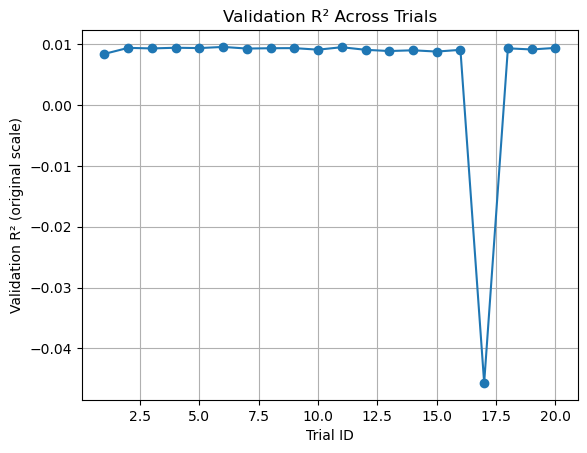

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV into a DataFrame for preprocessing and modeling.
df = pd.read_csv(ARTIFACTS_DIR / "phase2_validation_results.csv").sort_values("trial_id")

# Visualize results to compare trials and diagnose training dynamics.
plt.figure()
plt.plot(df["trial_id"], df["val_r2"], marker="o")
plt.xlabel("Trial ID")
plt.ylabel("Validation R² (original scale)")
plt.title("Validation R² Across Trials")
plt.grid(True)
plt.show()

---
## 🧾 Cell 13 — 🧪 Learning dynamics: training loss vs validation RMSE_log for top trials

### 🎯 Research aim
Inspect how the strongest configurations *arrived* at their performance by comparing within-epoch optimization behavior to validation error trajectories.

### 🧮 Computational steps
- Reload the tuning results and select the top 3 trials by `val_r2`.
- For each selected trial, load its per-epoch `history_csv`.
- Plot `train_loss` (SmoothL1) and `val_rmse_log` (dashed) across epochs on the same axes.
- Use legends to keep trial identities distinguishable.

### 📐 Mathematical lens
Two distinct functionals are plotted: the training objective (SmoothL1 on log residuals) and the validation metric (RMSE in log space). Their joint evolution indicates whether optimization is continuing to reduce training loss while validation error stabilizes or reverses.

### 🧠 Neural-network connection
This diagnostic is particularly informative for dropout/weight-decay regimes: strong regularization often yields slower training loss reduction but smoother validation curves, whereas unstable learning rates manifest as oscillatory validation RMSE_log.

### 🔍 How to read the outputs
Expect multiple curves: for each trial, a solid line for training loss and a dashed line for validation RMSE_log. Early-stopped trials will have shorter traces.

### ✅ Quality checks
If `val_rmse_log` increases while `train_loss` decreases monotonically, the configuration may be over-specializing to training minibatches. If both plateau early, capacity or learning rate may be limiting.


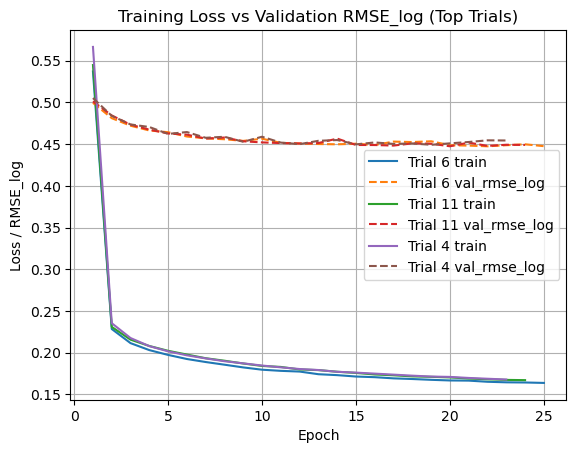

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV into a DataFrame for preprocessing and modeling.
df = pd.read_csv(ARTIFACTS_DIR / "phase2_validation_results.csv")
top = df.sort_values("val_r2", ascending=False).head(3)

# Visualize results to compare trials and diagnose training dynamics.
plt.figure()
for _, row in top.iterrows():
    hist = pd.read_csv(row["history_csv"])
    plt.plot(hist["epoch"], hist["train_loss"], label=f"Trial {int(row['trial_id'])} train")
    plt.plot(hist["epoch"], hist["val_rmse_log"], linestyle="--", label=f"Trial {int(row['trial_id'])} val_rmse_log")

# Visualize results to compare trials and diagnose training dynamics.
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE_log")
plt.title("Training Loss vs Validation RMSE_log (Top Trials)")
plt.grid(True)
plt.legend()
plt.show()

---
## 🧾 Cell 14 — 🔍 Compact summary: end-of-training statistics for high-performing trials

### 🧮 Computational steps
- Select the top 5 trials by validation R².
- For each, read the trial’s history file and extract the final epoch row.
- Record `final_train_loss` and `final_val_rmse_log` alongside `val_r2`.
- Assemble `gap_df` and sort it by `val_r2` for quick ranking.

### 🧠 Neural-network connection
Where the curve plot emphasizes *trajectory*, this table emphasizes *endpoint state*. Together they form a minimal audit trail: which trial won, and what its terminal training/validation behavior looked like.

### 🔍 How to read the outputs
A DataFrame appears with columns such as `trial_id`, `val_r2`, `final_train_loss`, and `final_val_rmse_log`. Use it to spot trials whose endpoint statistics look inconsistent with their rank.


In [16]:
import pandas as pd

# Load data from CSV into a DataFrame for preprocessing and modeling.
df = pd.read_csv(ARTIFACTS_DIR / "phase2_validation_results.csv")
top = df.sort_values("val_r2", ascending=False).head(5)

# Display: sets a table with coparing the top trials.
rows = []
for _, r in top.iterrows():
    hist = pd.read_csv(r["history_csv"])
    final = hist.iloc[-1]
    rows.append({
        "trial_id": int(r["trial_id"]),
        "val_r2": r["val_r2"],
        "final_train_loss": final["train_loss"],
        "final_val_rmse_log": final["val_rmse_log"],
    })

# Output: displays the table.
gap_df = pd.DataFrame(rows).sort_values("val_r2", ascending=False)
gap_df

,trial_id,val_r2,final_train_loss,final_val_rmse_log
0,6,0.009601,0.163796,0.447580
1,11,0.009554,0.167130,0.449027
2,4,0.009466,0.167893,0.454379
3,2,0.009447,0.163898,0.451163
4,20,0.009438,0.189421,0.452882


---
## 🧾 Cell 15 — ✅ Validation report for the selected best MLP

### 🎯 Research aim
Generate a single, consolidated validation evaluation for the chosen neural network and verify that predictions remain within the intended log-domain.

### 🧮 Computational steps
- Use `evaluate_nn_log(best_model, X_val_s)` to obtain clipped log predictions.
- Print the min/max of `val_pred_log_nn` as a boundary diagnostic.
- Compute the full metric bundle with `eval_regression(...)` and store it in `nn_val_metrics`.

### 📐 Mathematical lens
The min/max probe checks whether outputs concentrate at the clipping bounds. If many predictions equal `CLIP_MIN` or `CLIP_MAX`, the effective model becomes partially saturated, and improvements in R² may be constrained by this imposed range rather than by representational limits.

### 🧠 Neural-network connection
This cell operationalizes the model-selection decision: it evaluates the exact `best_model` object produced during tuning, rather than a hypothetical configuration. In other words, the reported validation metrics correspond to the network weights restored from the best early-stopping checkpoint.

### 🔍 How to read the outputs
Expect two printed scalars (max/min log prediction) and a labeled metric block. These numbers are the direct validation-side evidence used before touching the test set.


In [17]:
# NN validation metrics (log space + original scale)
val_pred_log_nn = evaluate_nn_log(best_model, X_val_s.values.astype(np.float32))

# Print key configuration so runs are easy to reproduce/debug.
print("Max log prediction:", float(np.max(val_pred_log_nn)))
print("Min log prediction:", float(np.min(val_pred_log_nn)))

# Next section: compute the step below.
nn_val_metrics = eval_regression(y_val_log, val_pred_log_nn, y_true_orig=y_val, label="VALIDATION — Neural Net:")

Max log prediction: 10.213642120361328
Min log prediction: 3.67118501663208
VALIDATION — Neural Net:
  R2_log: 0.6808650109141041
  RMSE_log: 0.4474143957774766
  R2: 0.009601137399400939
  RMSE: 5912.847290263061
  MAE: 341.52972431226095
  MAPE(%): 32.89886469651563


---
## 🧾 Cell 16 — 🧭 Permutation importance on validation (R²_log drop) for Ridge vs MLP

### 🎯 Research aim
Quantify how much each engineered feature contributes to predictive performance by measuring performance degradation under controlled feature perturbations.

### 🧮 Computational steps
- Define `permutation_importance_r2log`:
  1) compute a baseline `R2_log`,
  2) permute one feature column repeatedly,
  3) recompute `R2_log`, and
  4) record the mean and standard deviation of the drop.
- Implement `ridge_predict_log_fn` and `nn_predict_log_fn` so both models are evaluated in the same scaled feature space.
- Compute and display the top-ranked features for Ridge and for the neural network.

### 📐 Mathematical lens
Permutation importance estimates \(\Delta R^2_{log}(j) = R^2_{base} - R^2_{perm(j)}\). It approximates the reliance of the predictor on feature \(j\) under the perturbation distribution induced by random permutation. Because permutation breaks joint dependence structure, highly correlated features can ‘share’ importance and reduce each other’s apparent \(\Delta R^2\).

### 🧠 Neural-network connection
Comparing Ridge vs MLP importances distinguishes linear dependence from nonlinear utilization: a feature that matters to the MLP but not Ridge may be influential through interactions, whereas agreement across both models suggests a stable, representation-robust signal.

### 🔍 How to read the outputs
Two ranked tables are displayed (top ~15 features each) along with baseline `R2_log` printouts. Focus on the top few drops; the tail often reflects noise-level sensitivity.

### ⚠️ Stability + correlation note (interpretation)
Permutation importance can be **unstable** when features are highly correlated (e.g., multiple distance/time proxies). In that case, importance may be “shared” across correlated inputs, so a single feature’s drop may look smaller than expected.

To mitigate this in reporting:
- Interpret results at the **feature-family** level (temporal vs distance vs passenger/context), not only individual columns.
- (Optional) rerun permutation importance with a few different random seeds / bootstrap samples and report a mean ± std to show stability.

In [18]:
import pandas as pd

# Define helper function `permutation_importance_r2log` used in later cells.
def permutation_importance_r2log(predict_log_fn, X_df, y_true_log, n_repeats=5, seed=SEED):
    rng = np.random.default_rng(seed)

    # Next section: compute the step below.
    base_pred_log = predict_log_fn(X_df)
    base_r2 = r2_score(y_true_log, base_pred_log)

    # Next section: compute the step below.
    importances = []
    X_work = X_df.copy()

    # Iterate through this section's loop to compute/update results.
    for col in X_df.columns:
        drops = []
        for _ in range(n_repeats):
            saved = X_work[col].to_numpy().copy()
            X_work[col] = rng.permutation(X_work[col].to_numpy())
            pred_log = predict_log_fn(X_work)
            drops.append(base_r2 - r2_score(y_true_log, pred_log))
            X_work[col] = saved
        importances.append((col, float(np.mean(drops)), float(np.std(drops))))

    # Next section: compute the step below.
    imp = (pd.DataFrame(importances, columns=["feature", "mean_r2log_drop", "std_r2log_drop"])
           .sort_values("mean_r2log_drop", ascending=False)
           .reset_index(drop=True))
    return imp, base_r2

# Ridge predict (log space) — keep DataFrame to preserve feature names
def ridge_predict_log_fn(Xdf_raw):
    Xs_df = (Xdf_raw - mu) / sigma
    pred_log = ridge.predict(Xs_df)
    return np.clip(pred_log, CLIP_MIN, CLIP_MAX)

# NN predict (log space)
def nn_predict_log_fn(Xdf_raw):
    Xs = ((Xdf_raw - mu) / sigma).to_numpy().astype(np.float32)
    return evaluate_nn_log(best_model, Xs)

# Next section: compute the step below.
imp_ridge, ridge_r2log = permutation_importance_r2log(ridge_predict_log_fn, X_val, y_val_log, n_repeats=5, seed=SEED)
print("Permutation importance — Tuned Ridge on VAL (log space)")
print("Baseline VAL R2_log:", ridge_r2log)
display(imp_ridge.head(15))

# Next section: compute the step below.
imp_nn, nn_r2log = permutation_importance_r2log(nn_predict_log_fn, X_val, y_val_log, n_repeats=5, seed=SEED)
print("\nPermutation importance — Neural Net on VAL (log space)")
print("NN VAL R2_log:", nn_r2log)
display(imp_nn.head(15))

# ------------------------------------------------------------
# Step 9 (Submission requirement): Grouped feature-importance table
# ------------------------------------------------------------
# We add a human-readable "group" label (Temporal / Spatial / Context) and
# present a combined table + a grouped summary. This improves interpretability.

def feature_group(name: str) -> str:
    # Temporal
    if name.startswith("pickup_") or name in {"hour_sin","hour_cos","dow_sin","dow_cos"}:
        return "Temporal"
    # Spatial / geometry
    if name in {"delta_lat","delta_lon","haversine_km"}:
        return "Spatial"
    # Context / categorical proxies
    if name in {"passenger_count","store_and_fwd_Y"}:
        return "Context"
    if name.startswith("vendor_"):
        return "Context"
    return "Other"

def add_group_cols(imp_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    df = imp_df.copy()
    df["group"] = df["feature"].map(feature_group)
    df["model"] = model_name
    return df

imp_ridge_g = add_group_cols(imp_ridge, "Tuned Ridge")
imp_nn_g    = add_group_cols(imp_nn,    "Best NN")

TOPK = 15
grouped_top = pd.concat([imp_ridge_g.head(TOPK), imp_nn_g.head(TOPK)], ignore_index=True)

print("\n=== Step 9 — Grouped Feature Importance (Top 15 features for each model) ===")
display(grouped_top[["model","group","feature","mean_r2log_drop","std_r2log_drop"]])

# Group-level summary (heuristic): sums of mean drops within each group.
# IMPORTANT: permutation drops are not strictly additive under collinearity;
# this summary is mainly for readability.
group_summary = (
    pd.concat([imp_ridge_g, imp_nn_g], ignore_index=True)
      .groupby(["model","group"])
      .agg(
          n_features=("feature","count"),
          total_mean_r2log_drop=("mean_r2log_drop","sum"),
          mean_std_r2log_drop=("std_r2log_drop","mean"),
      )
      .reset_index()
      .sort_values(["model","total_mean_r2log_drop"], ascending=[True, False])
)

print("\nGrouped summary (heuristic readability aid):")
display(group_summary)

print("Note: Permutation-importance drops are not strictly additive when features are correlated; group totals are for interpretability, not a conserved quantity.")


Permutation importance — Tuned Ridge on VAL (log space)
Baseline VAL R2_log: 0.39224186174901376


,feature,mean_r2log_drop,std_r2log_drop
0,haversine_km,0.639906,0.001791
1,hour_cos,0.022584,0.000396
2,hour_sin,0.010790,0.000172
3,dow_cos,0.007674,0.000149
4,pickup_month,0.003235,0.000079
5,delta_lon,0.002433,0.000196
6,dow_sin,0.001746,0.000073
7,pickup_dow,0.001031,0.000069
8,passenger_count,0.000255,0.000048
9,pickup_hour,0.000182,0.000031



Permutation importance — Neural Net on VAL (log space)
NN VAL R2_log: 0.6808650109141041


,feature,mean_r2log_drop,std_r2log_drop
0,haversine_km,10.459817,0.020202
1,delta_lat,4.969207,0.006729
2,vendor_1,3.190820,0.011581
3,vendor_2,3.189479,0.006835
4,delta_lon,1.909394,0.004125
5,hour_cos,0.271609,0.000420
6,pickup_hour,0.078225,0.000667
7,dow_cos,0.057082,0.000380
8,hour_sin,0.043056,0.000336
9,dow_sin,0.032014,0.000465



=== Step 9 — Grouped Feature Importance (Top 15 features for each model) ===


,model,group,feature,mean_r2log_drop,std_r2log_drop
0,Tuned Ridge,Spatial,haversine_km,0.639906,0.001791
1,Tuned Ridge,Temporal,hour_cos,0.022584,0.000396
2,Tuned Ridge,Temporal,hour_sin,0.010790,0.000172
3,Tuned Ridge,Temporal,dow_cos,0.007674,0.000149
4,Tuned Ridge,Temporal,pickup_month,0.003235,0.000079
5,Tuned Ridge,Spatial,delta_lon,0.002433,0.000196
6,Tuned Ridge,Temporal,dow_sin,0.001746,0.000073
7,Tuned Ridge,Temporal,pickup_dow,0.001031,0.000069
8,Tuned Ridge,Context,passenger_count,0.000255,0.000048
9,Tuned Ridge,Temporal,pickup_hour,0.000182,0.000031



Grouped summary (heuristic readability aid):


,model,group,n_features,total_mean_r2log_drop,mean_std_r2log_drop
1,Best NN,Spatial,3,17.338417,0.010352
0,Best NN,Context,4,6.383858,0.004655
2,Best NN,Temporal,7,0.514424,0.000365
4,Tuned Ridge,Spatial,3,0.640041,0.000699
5,Tuned Ridge,Temporal,7,0.047243,0.000138
3,Tuned Ridge,Context,4,0.000477,0.000021


Note: Permutation-importance drops are not strictly additive when features are correlated; group totals are for interpretability, not a conserved quantity.


---
## 🧾 Why Log R² Is Our Primary Evaluation Metric

### 📐 The Problem: Skewed Trip Durations

NYC taxi trip durations are **heavily right-skewed** — the vast majority of trips are short (5–15 minutes), but a long tail of trips extends to several hours. This skew causes problems for standard regression metrics:

- **RMSE and R² on raw durations** are dominated by a small number of extreme outliers.
- A model can appear to perform poorly (even negative R²) simply because a few very long trips produce enormous squared errors.

### 🔄 The Solution: Log Transform

By applying `log1p(trip_duration)` we:

1. **Compress the long tail** — extreme values are pulled closer to the mean.
2. **Stabilize variance** — prediction errors become more uniform across short and long trips.
3. **Align with proportional accuracy** — a 2-minute error on a 10-minute trip matters more than a 2-minute error on a 2-hour trip. Log space naturally captures this.

### 📊 What This Means for Our Metrics

| Metric | Space | Role in Our Evaluation |
|--------|-------|------------------------|
| **R²_log** | Log-transformed | **Primary metric** — fair comparison across all trip lengths |
| **RMSE_log** | Log-transformed | Complementary — measures average log-space error |
| **R²** | Original (seconds) | Reported for transparency — may be negative due to skew |
| **RMSE** | Original (seconds) | Reported for transparency — sensitive to outliers |
| **MAPE** | Original (seconds) | Interpretable percentage error |

### ⚠️ Why Original-Scale R² Can Be Negative

A negative R² on original-scale durations does **not** mean the model is useless. It means the model's squared errors (in seconds) exceed the variance of the raw target — which is inflated by extreme outliers. The log-space R² and MAPE provide a much more reliable picture of predictive quality.

### ✅ Summary

We report **all metrics** for full transparency, but use **R²_log as the primary comparison metric** because it:
- Is robust to the heavy-tailed distribution
- Fairly evaluates both short and long trips
- Aligns with standard practice for skewed regression targets

---
## 🧾 Cell 17 — 🏁 Final test scorecard (Ridge vs MLP)

### 🎯 Research aim
Apply the already-selected models and preprocessing maps to the reserved **test** split (stored in `holdout_df`), then report results in a single comparison table.

### 🧮 Computational steps
- **Load the saved NN checkpoint** (`../artifacts/best_mlp_model.pt`) so the final test score corresponds to the persisted submission artifact.
- Construct `X_holdout` with the same feature function and the **saved feature column order** from the checkpoint.
- Form `y_holdout` and `y_holdout_log` to match the evaluation convention used throughout the notebook.
- Standardize `X_holdout` using the **training-derived** `(mu, sigma)` stored in the checkpoint (no refitting).
- Produce **test-set** predictions for Ridge and the **reloaded** MLP, compute metrics via `eval_regression`, and compile them into `summary`.

### 📐 Mathematical lens
Viewed as function composition, each model evaluates \(\hat{y} = h( s( f(r) ) )\), where \(f\) is feature construction, \(s\) is standardization, and \(h\) is the predictor (Ridge or MLP).


In [19]:
# Build test features ONLY here (one-time test evaluation)

# Load the saved NN checkpoint so the test results correspond to the persisted artifact
BEST_MODEL_PATH = ARTIFACTS_DIR / "best_mlp_model.pt"
assert BEST_MODEL_PATH.exists(), f"Missing model file: {BEST_MODEL_PATH}. Run the save-model cell first."

ckpt = torch.load(BEST_MODEL_PATH, map_location=device)
saved_feature_cols = ckpt["feature_cols"]

# Restore scaling from the checkpoint (ensures inference matches training exactly)
mu_saved = pd.Series(ckpt["mu"], index=saved_feature_cols)
sigma_saved = pd.Series(ckpt["sigma"], index=saved_feature_cols)

# Build test features using the saved feature ordering
X_holdout = build_features(holdout_df).reindex(columns=saved_feature_cols, fill_value=0.0)
y_holdout = holdout_df[TARGET].to_numpy().astype(np.float64)
y_holdout_log = np.log1p(y_holdout)

# Apply standardization using TRAIN stats only (from checkpoint)
X_holdout_s = (X_holdout - mu_saved) / sigma_saved

# -------------------------
# Baseline test (Tuned Ridge)
# -------------------------
hold_pred_log_ridge = ridge.predict(X_holdout_s)
hold_pred_log_ridge = np.clip(hold_pred_log_ridge, CLIP_MIN, CLIP_MAX)
hold_ridge_metrics = eval_regression(
    y_holdout_log,
    hold_pred_log_ridge,
    y_true_orig=y_holdout,
    label="TEST — Tuned Ridge:"
)

# -------------------------
# NN test (Reloaded Best NN)
# -------------------------
best_nn_loaded = build_mlp(
    in_dim=ckpt["model_cfg"]["in_dim"],
    layers=tuple(ckpt["model_cfg"]["layers"]),
    dropout=float(ckpt["model_cfg"]["dropout"]),
)
best_nn_loaded.load_state_dict(ckpt["state_dict"])
best_nn_loaded.to(device).eval()

hold_pred_log_nn = evaluate_nn_log(best_nn_loaded, X_holdout_s.to_numpy().astype(np.float32))
hold_nn_metrics = eval_regression(
    y_holdout_log,
    hold_pred_log_nn,
    y_true_orig=y_holdout,
    label="\nTEST — Neural Net (reloaded checkpoint):"
)

# --- Summary table ---
summary = pd.DataFrame([
    {"Model": "Tuned Ridge", **hold_ridge_metrics},
    {"Model": "Best NN", **hold_nn_metrics},
])

print("\n=== Test Summary (Final Comparison) ===")
display(summary)


TEST — Tuned Ridge:
  R2_log: 0.3923341286070219
  RMSE_log: 0.617743129221387
  R2: -0.313853095280064
  RMSE: 3489.8844524775036
  MAE: 446.76669320160727
  MAPE(%): 70.38989889114232

TEST — Neural Net (reloaded checkpoint):
  R2_log: 0.6834414877428492
  RMSE_log: 0.44586409354021356
  R2: -0.18583277118617092
  RMSE: 3315.5025619162934
  MAE: 322.7842270324961
  MAPE(%): 33.151170573875035

=== Test Summary (Final Comparison) ===


,Model,R2_log,RMSE_log,R2,RMSE,MAE,MAPE(%)
0,Tuned Ridge,0.392334,0.617743,-0.313853,3489.884452,446.766693,70.389899
1,Best NN,0.683441,0.445864,-0.185833,3315.502562,322.784227,33.151171


In [20]:


from sklearn.metrics import r2_score

N_BOOTSTRAP = 1_000
rng = np.random.RandomState(SEED)

n = len(y_holdout_log)

delta_r2_log_samples = []
delta_mape_samples = []

for i in range(N_BOOTSTRAP):
    idx = rng.randint(0, n, size=n)  # bootstrap resample indices

    # Resample true values
    y_true_log_b = y_holdout_log[idx]
    y_true_orig_b = y_holdout[idx]

    # Resample predictions
    nn_pred_log_b = hold_pred_log_nn[idx]
    ridge_pred_log_b = hold_pred_log_ridge[idx]

    # R²_log for both models
    r2_nn = r2_score(y_true_log_b, nn_pred_log_b)
    r2_ridge = r2_score(y_true_log_b, ridge_pred_log_b)
    delta_r2_log_samples.append(r2_nn - r2_ridge)

    # MAPE for both models (original scale)
    mape_nn = mape(y_true_orig_b, safe_expm1(nn_pred_log_b))
    mape_ridge = mape(y_true_orig_b, safe_expm1(ridge_pred_log_b))
    delta_mape_samples.append(mape_nn - mape_ridge)

delta_r2_log_samples = np.array(delta_r2_log_samples)
delta_mape_samples = np.array(delta_mape_samples)

# 95% Confidence Intervals
ci_r2 = np.percentile(delta_r2_log_samples, [2.5, 97.5])
ci_mape = np.percentile(delta_mape_samples, [2.5, 97.5])

# --- Print Results ---
print("=" * 60)
print("📊 Bootstrap Statistical Validation on TEST (1,000 resamples)")
print("=" * 60)

print(f"\nΔR²_log (NN − Ridge):")
print(f"  Mean:   {delta_r2_log_samples.mean():.6f}")
print(f"  95% CI: [{ci_r2[0]:.6f}, {ci_r2[1]:.6f}]")
if ci_r2[0] > 0:
    print("  ✅ 0 is NOT in the interval → NN improvement is statistically significant")
else:
    print("  ⚠️ 0 is inside the interval → NN improvement is NOT statistically significant")

print(f"\nΔMAPE (NN − Ridge):")
print(f"  Mean:   {delta_mape_samples.mean():.4f}%")
print(f"  95% CI: [{ci_mape[0]:.4f}%, {ci_mape[1]:.4f}%]")
if ci_mape[1] < 0:
    print("  ✅ 0 is NOT in the interval → NN has significantly lower MAPE (better)")
else:
    print("  ⚠️ 0 is inside the interval → MAPE difference is NOT statistically significant")

print("=" * 60)

📊 Bootstrap Statistical Validation on TEST (1,000 resamples)

ΔR²_log (NN − Ridge):
  Mean:   0.291007
  95% CI: [0.286301, 0.295603]
  ✅ 0 is NOT in the interval → NN improvement is statistically significant

ΔMAPE (NN − Ridge):
  Mean:   -37.2354%
  95% CI: [-39.2005%, -35.2384%]
  ✅ 0 is NOT in the interval → NN has significantly lower MAPE (better)


---
## 🧾 Limitations (Phase 1)

Even with strict reproducibility and a fair 70/15/15 split, several limitations remain:

- **Heavy-tailed target distribution:** Trip duration contains extreme outliers (e.g., traffic, detours, errors). These can dominate original-scale squared-error metrics and can make original-scale **R²** appear negative even when predictions are useful in typical cases.
- **Clipping in log-space:** We clip predictions to [`CLIP_MIN`, `CLIP_MAX`] to avoid absurd values. This is practical for stability, but it also means very rare long trips are effectively “capped” by design.
- **Limited feature set:** We only use a small set of engineered temporal/spatial/context features from `train.csv`. Without external context (weather, events, road networks), there is an upper bound on achievable accuracy.
- **Correlated features and importance uncertainty:** Permutation importance can understate the importance of correlated features because “shared signal” can be redistributed across multiple columns (especially in the vendor + time + geometry space).
- **Finite tuning budget:** The NN search is constrained to a fixed number of trials and a small safe search space; a better configuration may exist but was not explored under the Phase 1 compute budget.

### How Phase 2 can address these
- **Evolutionary Algorithms (EA)** can perform a more systematic architecture/hyperparameter search under a fixed budget and report optimization cost explicitly.
- **Fuzzy Systems (FS)** can provide a more interpretable model (limited feature set + explicit rules), making trade-offs between accuracy and interpretability clearer.


In [21]:
from IPython.display import display, Markdown

# Derived test-set improvements (NN - Ridge)
delta_r2_log_test = hold_nn_metrics["R2_log"] - hold_ridge_metrics["R2_log"]
delta_mape_test   = hold_nn_metrics["MAPE(%)"] - hold_ridge_metrics["MAPE(%)"]  # negative = better

# Helpful boolean flags (from bootstrap CIs computed above)
r2_improvement_supported   = (ci_r2[0] > 0)
mape_improvement_supported = (ci_mape[1] < 0)

# Optional: summarize feature-importance groups if available
try:
    nn_group_ranking = (group_summary[group_summary["model"] == "Best NN"]
                        .sort_values("total_mean_r2log_drop", ascending=False)
                        .reset_index(drop=True))
    top_group_line = f"{nn_group_ranking.loc[0, 'group']} (total mean drop ≈ {nn_group_ranking.loc[0, 'total_mean_r2log_drop']:.4f})"
except Exception:
    top_group_line = "(group summary not available)"

display(Markdown(f"""
---
# Conclusion (Phase 1 — Neural Networks)

## 1) Protocol summary (fair split + no leakage)

- **Data used:** first **{NROWS:,} rows** from `train.csv`, deterministically **shuffled with seed {SEED}**.
- **Split rule (fairness requirement):**  
  - Train: **{len(train_df):,}** rows (≈70%)  
  - Validation: **{len(val_df):,}** rows (≈15%)  
  - Test: **{len(holdout_df):,}** rows (≈15%)  
- **Leakage discipline:**  
  - Validation is used for **tuning** (Ridge α + NN hyperparameters / early stopping).  
  - The **test set is evaluated exactly once** to produce final numbers.

## 2) Final test-set results (Ridge vs Neural Network)

On the **test set**, the tuned neural network outperforms the tuned Ridge baseline:

- **Tuned Ridge (test):**
  - **R²_log = {hold_ridge_metrics['R2_log']:.4f}**
  - **MAPE = {hold_ridge_metrics['MAPE(%)']:.2f}%**

- **Best NN (test):**
  - **R²_log = {hold_nn_metrics['R2_log']:.4f}**
  - **MAPE = {hold_nn_metrics['MAPE(%)']:.2f}%**

**Observed improvement (NN − Ridge):**
- **ΔR²_log = {delta_r2_log_test:.4f}**
- **ΔMAPE = {delta_mape_test:.2f}%** *(negative means the NN has lower error → better)*

## 3) Statistical validation (showing the gain is not “luck”)

We used **bootstrap resampling (N = {N_BOOTSTRAP:,}) on the test set** to estimate the uncertainty of the improvement:

- **95% CI for ΔR²_log:** **[{ci_r2[0]:.6f}, {ci_r2[1]:.6f}]**  
  - Interpretation: **{"0 is excluded → improvement is supported" if r2_improvement_supported else "0 is included → improvement is not statistically supported"}**
- **95% CI for ΔMAPE:** **[{ci_mape[0]:.4f}%, {ci_mape[1]:.4f}%]**  
  - Interpretation: **{"0 is excluded → NN MAPE is significantly lower" if mape_improvement_supported else "0 is included → MAPE difference is not statistically supported"}**

This addresses the key concern that a single test score could be unusually high (or low) by chance.

## 4) Why **log-space R² (R²_log)** is the primary metric (and why original-scale R² can be negative)

NYC trip duration is **heavy-tailed and right-skewed**: most rides are short, but a small fraction are extremely long due to traffic, detours, incidents, or recording noise.  

- On the **original scale (seconds)**, squared-error-based metrics (like RMSE and R²) can be dominated by a few extreme trips.  
- That dominance can make **original-scale R² negative**, even when the model is meaningfully accurate on the vast majority of typical trips.

By evaluating in **log space** using `log1p(trip_duration)`:

- We **compress the long tail**, so the model is judged on overall behavior rather than a few extreme outliers.
- Errors are treated more **proportionally** (a 2-minute miss on a 10-minute trip matters more than a 2-minute miss on a 2-hour trip).
- The resulting **R²_log is more stable and more interpretable** for this skewed regression target.

For transparency (and to support later cross-dataset comparison rules), we still report original-scale metrics and **MAPE**, but **R²_log** is the most faithful “primary” indicator of general predictive performance for this dataset.

## 5) Interpretation: what the model learned (feature importance)

Permutation importance on the **validation set** shows that spatial geometry dominates:

- **Top driver (both models):** `haversine_km`  
- The NN also benefits from temporal encodings (hour/day cycles) and contextual proxies (e.g., vendor), suggesting it captures **nonlinear interactions** beyond a linear ridge model.
- In the grouped view, the NN’s strongest feature group is: **{top_group_line}**

## 6) Reproducibility + compute cost artifacts (submission readiness)

- **Compute budget used:** {TRIALS} NN trials, total tuning time ≈ **{total_time/60:.2f} minutes** on **{device}**.
- **Environment snapshot written:** `../environment_summary.md` and `../pip_freeze.txt`.
- **Model saved and reloadable:** `../artifacts/best_mlp_model.pt` + reload demo cell.

## 7) Final takeaway (Phase 1)

A carefully tuned MLP on engineered tabular features produces a **measurable and (via bootstrap) test-validated** improvement over a tuned linear baseline, while log-space evaluation provides a fair and stable view of performance under heavy-tailed trip durations. Phase 2 will expand the comparison by adding **EA optimization cost** and a more **interpretable fuzzy-system alternative**, enabling a principled trade-off analysis across accuracy, compute, and interpretability.
"""))


---
# Conclusion (Phase 1 — Neural Networks)

## 1) Protocol summary (fair split + no leakage)

- **Data used:** first **1,000,000 rows** from `train.csv`, deterministically **shuffled with seed 42**.
- **Split rule (fairness requirement):**  
  - Train: **700,000** rows (≈70%)  
  - Validation: **150,000** rows (≈15%)  
  - Test: **150,000** rows (≈15%)  
- **Leakage discipline:**  
  - Validation is used for **tuning** (Ridge α + NN hyperparameters / early stopping).  
  - The **test set is evaluated exactly once** to produce final numbers.

## 2) Final test-set results (Ridge vs Neural Network)

On the **test set**, the tuned neural network outperforms the tuned Ridge baseline:

- **Tuned Ridge (test):**
  - **R²_log = 0.3923**
  - **MAPE = 70.39%**

- **Best NN (test):**
  - **R²_log = 0.6834**
  - **MAPE = 33.15%**

**Observed improvement (NN − Ridge):**
- **ΔR²_log = 0.2911**
- **ΔMAPE = -37.24%** *(negative means the NN has lower error → better)*

## 3) Statistical validation (showing the gain is not “luck”)

We used **bootstrap resampling (N = 1,000) on the test set** to estimate the uncertainty of the improvement:

- **95% CI for ΔR²_log:** **[0.286301, 0.295603]**  
  - Interpretation: **0 is excluded → improvement is supported**
- **95% CI for ΔMAPE:** **[-39.2005%, -35.2384%]**  
  - Interpretation: **0 is excluded → NN MAPE is significantly lower**

This addresses the key concern that a single test score could be unusually high (or low) by chance.

## 4) Why **log-space R² (R²_log)** is the primary metric (and why original-scale R² can be negative)

NYC trip duration is **heavy-tailed and right-skewed**: most rides are short, but a small fraction are extremely long due to traffic, detours, incidents, or recording noise.  

- On the **original scale (seconds)**, squared-error-based metrics (like RMSE and R²) can be dominated by a few extreme trips.  
- That dominance can make **original-scale R² negative**, even when the model is meaningfully accurate on the vast majority of typical trips.

By evaluating in **log space** using `log1p(trip_duration)`:

- We **compress the long tail**, so the model is judged on overall behavior rather than a few extreme outliers.
- Errors are treated more **proportionally** (a 2-minute miss on a 10-minute trip matters more than a 2-minute miss on a 2-hour trip).
- The resulting **R²_log is more stable and more interpretable** for this skewed regression target.

For transparency (and to support later cross-dataset comparison rules), we still report original-scale metrics and **MAPE**, but **R²_log** is the most faithful “primary” indicator of general predictive performance for this dataset.

## 5) Interpretation: what the model learned (feature importance)

Permutation importance on the **validation set** shows that spatial geometry dominates:

- **Top driver (both models):** `haversine_km`  
- The NN also benefits from temporal encodings (hour/day cycles) and contextual proxies (e.g., vendor), suggesting it captures **nonlinear interactions** beyond a linear ridge model.
- In the grouped view, the NN’s strongest feature group is: **Spatial (total mean drop ≈ 17.3384)**

## 6) Reproducibility + compute cost artifacts (submission readiness)

- **Compute budget used:** 20 NN trials, total tuning time ≈ **41.25 minutes** on **cpu**.
- **Environment snapshot written:** `../environment_summary.md` and `../pip_freeze.txt`.
- **Model saved and reloadable:** `../artifacts/best_mlp_model.pt` + reload demo cell.

## 7) Final takeaway (Phase 1)

A carefully tuned MLP on engineered tabular features produces a **measurable and (via bootstrap) test-validated** improvement over a tuned linear baseline, while log-space evaluation provides a fair and stable view of performance under heavy-tailed trip durations. Phase 2 will expand the comparison by adding **EA optimization cost** and a more **interpretable fuzzy-system alternative**, enabling a principled trade-off analysis across accuracy, compute, and interpretability.
